# Unstructured Text Analysis: Building Permits

### Problem Description

"Take a look at (the Analyze Boston data hub's) building permits dataset. You will see a free text column labeled 'Comments'. We are often tasked with looking at unstructured text and seeing if we can provide any useful insight on the data. Please provide the top ten comment 'themes'. A theme can be anything such as the type of work being done, a general logical bucket to group common terms, the longest recurring patterns in the text, etc."

### First Approaches

The building permits dataset contains about 380,000 entries.  We're interested in breaking down the text found in the "Comments" section to see what patterns might arise.  The challenge of natural language processing is to filter the data just the right amount: If you filter too little, patterns are lost in the noise of words.  If you filter too much, you can miss patterns that are truly there.

***

### Code Preparation

Import libraries and dataset.  I used the NLTK library (`pip install nltk`) for some of the data pre-processing.  I used random sampling on a smaller number of comments for troubleshooting.

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from random import sample
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

#random sampling
n = 49 #number of records in file
s = 20 #desired sample size
skip = sorted(sample(range(1,n+1),n-s))

#input path to the csv file here:
bp_df = pd.read_csv("/data/approvedbuildingpermits_sample.csv", encoding = "ISO-8859-1")#, skiprows=skip)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mnksmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mnksmith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mnksmith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


First, a look at the shape of the 'Comments' section of the dataset.  These word count statistics will help give an impression of what the content of a typical comment might look like, and how much variation there is between comments.

Word count range: (1, 661)
Mean: 14.2
Std Dev: 14.1


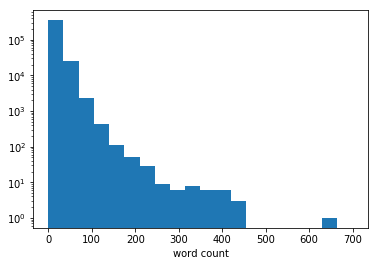

In [121]:
bp_df['word_count'] = bp_df['Comments'].apply(lambda x: len(str(x).split(" ")))
longest_comments = bp_df[['Comments','word_count']].sort_values(by='word_count', ascending=False).head(10)
mean_word_count = bp_df['word_count'].mean()
std_word_count = bp_df['word_count'].std()
print('Word count range: (%i, %i)' % (bp_df['word_count'].min(), bp_df['word_count'].max()))
print('Mean: %.1f' % (mean_word_count))
print('Std Dev: %.1f' % (std_word_count))
plt.figure()
plt.hist(bp_df['word_count'], bins=20, range=(0,700), log=True)
plt.xlabel('word count')
plt.show()

Most comments are short--50% are 14 words or shorter and more than 80% are 28 words or shorter.  A handful of comments, however, are very long, creating a tail.

Now let's do some pre-processing on the comments to clean the data and make the features clearer and the themes pop out.

1. Make everything lower case.
2. Remove punctuation.
3. Remove stop words.  Stop words are words that should be filtered out for the analysis because they occur very frequently in the English language ('and', 'the', etc).  I will use the NLTK library.

In [122]:
bp_test = bp_df.copy()
#lowercase
bp_test['Comments'] = bp_test['Comments'].apply(lambda x: " ".join(x.lower() for x in re.split('\W+|/', str(x))))
#no punctuation
bp_test['Comments'] = bp_test['Comments'].str.replace('[^\w\s]','')
#no stop words
stop = stopwords.words('english')
bp_test['Comments'] = bp_test['Comments'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

print(bp_test['Comments'].head(5))


0    change connector link layout attached enclosed walkway partially enclose walkway canopy
1    landscaping stonework amending permit 2801 2006 per b r                                
2    interior exterior work indicated drawings amending permit 2465 2009                    
3    landmark letter permit submittal existing issued application alt20670                  
4    amendment add bathroom bedroom 3rd floor                                               
Name: Comments, dtype: object


We want to be sure to group words together if they are the same word but different parts of speech (e.g. 'change', 'changes').  Lemmatization will convert each word into its root.  I use the TextBlob library (`pip install textblob`), which uses morphology to find the proper stems.

In [123]:
from textblob import Word
bp_test['Comments'] = bp_test['Comments'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
print(bp_test['Comments'].head(5))

0    change connector link layout attached enclosed walkway partially enclose walkway canopy
1    landscaping stonework amending permit 2801 2006 per b r                                
2    interior exterior work indicated drawing amending permit 2465 2009                     
3    landmark letter permit submittal existing issued application alt20670                  
4    amendment add bathroom bedroom 3rd floor                                               
Name: Comments, dtype: object


***

### Results and Data Analysis

Finally we're ready to have a look at the most common words across all comments.

In [278]:
freq = pd.Series(' '.join(bp_test['Comments']).split())
word_freq = freq.value_counts()[freq.value_counts()>10]
print(word_freq.sort_values(ascending=False).head(50))

new             121536
install         101056
floor           66006 
existing        64818 
replace         57700 
2               47850 
kitchen         42845 
1               39705 
3               35752 
system          34547 
unit            33242 
work            32523 
bathroom        31733 
water           31164 
gas             30628 
wall            27872 
roof            27199 
renovation      25301 
remove          24900 
office          23849 
4               23563 
fire            23141 
electrical      22136 
issued          21068 
panel           20215 
alarm           20156 
building        19928 
installation    19719 
heater          19102 
repair          18920 
area            18844 
window          18466 
room            17843 
light           17691 
wiring          17585 
fixture         17556 
5               17346 
space           16963 
replacement     16857 
6               16525 
door            16414 
plumbing        16290 
interior        15983 
family     

Just the word count can give some sense of what themes can be found in the comments.  "New", "install", "installation", "add" imply a fresh project, while "replace", "renovation", "remove", "repair", "replacement", "change" imply adjustments to an existing installation.  The common words also cluster around topics: 

1. Water systems ("water", "bathroom", "plumbing", "boiler", "bath", "sink")
2. Electrical systems ("electrical", "panel", "light", "wiring", "fixture", "lighting", "wire")
3. Building planning ("wall", "roof", "window", "room", "space", "door", "interior", "basement", "ceiling").

Many of these words are missing context, however, so let's look at short phrases as well by counting Ngrams.  Unfortunately I found the act of creating and summing grouped words from every comment in the entire data set extremely computationally expensive, so in the interest of time I will sample the data to find patterns in word pairs and phrases.  The entire dataset has around 380,000 entries, and I produce random samples of 10,000 comments.

This function vectorizes the text in each comment, builds a dictionary of the total vocabulary, and counts the number of times word groups of size n appear.

In [259]:
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_colwidth', -1)

bp_slim = bp_test.sample(n=10000)

def ngram_counter(bp_slim, n):
    c_vec = CountVectorizer(ngram_range=(n, n)) #vectorize the comments, choose ngrams
    ngrams = c_vec.fit_transform(bp_slim['Comments'].values.astype(str))
    vocab = c_vec.vocabulary_ #build dictionary
    count_values = ngrams.toarray().sum(axis=0) #count common ngrams
    
    ngram_df = pd.DataFrame(columns=['freq','phrase']).set_index('phrase')
    for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
        chunk_df = pd.DataFrame([ng_count], index=[ng_text], columns=['freq'])
        ngram_df = ngram_df.add(chunk_df,fill_value=0) #save most common phrases in a dataframe
 #   print(ngram_df.sort_values(by='freq', ascending=False).head(10))
    return ngram_df

Running the code and storing the resultant common ngrams in dataframes:

**Note**: this code takes some time to run.

In [260]:
bigram_df = ngram_counter(bp_slim, 2)
trigram_df = ngram_counter(bp_slim, 3)
quadgram_df = ngram_counter(bp_slim, 4)
pentagram_df = ngram_counter(bp_slim, 5)
hexagram_df = ngram_counter(bp_slim, 6)
heptagram_df = ngram_counter(bp_slim, 7)
octagram_df = ngram_counter(bp_slim, 8)
nonagram_df = ngram_counter(bp_slim, 9)

Now we examine each ngram in turn for patterns.  Adjust the value in "head" to look at more values. Note that the data was re-sampled for each list of ngrams so there may not be internal consistency.  The purpose is to find qualitative trends in common elements.

In [269]:
print(bigram_df.sort_values(by='freq', ascending=False).head(5))

                freq
install new      780
water heater     457
fire alarm       401
low voltage      267
security system  233


In [270]:
print(trigram_df.sort_values(by='freq', ascending=False).head(5))

                        freq
fire alarm system        141
police detail area       112
detail area 343          111
boston police detail     99 
install security system  95 


In [271]:
print(quadgram_df.sort_values(by='freq', ascending=False).head(5))

                                  freq
police detail area 343             106
boston police detail area          97 
lighting energy efficient fixture  44 
replace lighting energy efficient  44 
boston police area 343             40 


In [272]:
print(pentagram_df.sort_values(by='freq', ascending=False).head(5))

                                          freq
boston police detail area 343              123
replace lighting energy efficient fixture  58 
4pm boston police detail area              35 
7am 4pm boston police detail               35 
solar electric panel roof existing         34 


In [273]:
print(hexagram_df.sort_values(by='freq', ascending=False).head(5))

                                           freq
misc low voltage hvac control wiring        32 
install solar electric panel roof existing  31 
boston police detail area 343 4239          28 
boston police detail area 343 4556          27 
4pm boston police detail area 343           24 


In [274]:
print(heptagram_df.sort_values(by='freq', ascending=False).head(5))

                                                         freq
7am 4pm boston police detail area 343                     24 
solar electric panel roof existing home interconnected    22 
electric panel roof existing home interconnected home     22 
roof existing home interconnected home electrical system  22 
panel roof existing home interconnected home electrical   22 


Here's a quick look at which words are most common in the single-word comments (after cleaning):

In [277]:
freq1 = pd.Series(' '.join(bp_test.loc[bp_test.word_count==1]['Comments']).split())
word_freq1 = freq1.value_counts()[freq1.value_counts()>10]
print(word_freq1.sort_values(ascending=False).head(5))

renovation    355
retest        291
boiler        213
plumbing      182
remodel       113
dtype: int64


After looking through the most-common words and groups of words, I've compiled ten themes.  I'll explore each in turn:


#### 1. Location on property

Many comments are used to specify where on the property/where in the building the activity is taking place.  "Interior" and "exterior" are common words and "1st floor", "2nd floor", "3rd floor", etc are common bigrams.  Work specific to a room is also frequently commented: "kitchen", "bathroom", "basement", etc.

#### 2. Energy-efficient upgrades

Improving energy efficiency appears in two categories: lighting fixtures and solar panels.  Longer ngrams frequently contain this information, so we see repeated instances of "install solar electric panel roof existing home", "roof mounted photovoltaic", or "lighting energy efficient fixture".

#### 3. HVAC (Heating, Ventilation, and Air Conditioning)

HVAC itself is a commonly-appearing term, but this theme is especially apparent in the frequency of electrical ngrams like "home electrical system", "low voltage hvac control", or "low voltage wiring" and heating system ngrams like "replace water heater", and "hot water heater".

#### 4. Exterior structural changes

Alterations made to building exteriors are evident in the item being addressed ("window", "wall", "door") and in longer phrases indicating renovation ("install replacement window structural").  This theme overlaps with the energy-efficient upgrades as many of the comments reference solar panel installation which falls into both categories.

#### 5. Interior remodeling

Interior remodeling is evident from the frequency of terms like "kitchen", "bath", "tiling", "carpeting", and more, and specific remodeling work is often spelled out in the longer ngrams like "bathtub surround remove replace kitchen cabinet installing new".

#### 6. Police detail areas

For trigrams and 4-grams police detail information is truly ubiquitous ("boston police detail area").  The specifics of the police detail often include the time of day when the police are stationed, as well as a phone number starting with 343.  Larger projects that could, for example, disrupt traffic would require police presence during the day.

#### 7. Plumbing

Plumbing is self-explanatory--common words include "plumbing", "bathroom", "kitchen", "sink", etc.  It also appears toward the top of the list of single-word comments.

#### 8. Fire alarm systems

Although none of these words are the very most common words in the comments, together as a trigram "fire alarm system" is the very most common.  Repair and reinstallation of fire alarms is a clear theme.

#### 9. Security systems

Longer ngrams include "install security system" and "low voltage wireless burglar alarm".  Much of the frequency of electrical system language can be attributed to security system installation as well.

#### 10. Occupancy changes

Various ngrams including "single"- or "two family dwelling" and "change occupancy" indicate that declaring occupancy changes is a common use of the comments section.

***

To better understand what kind of information can be drawn from these themes, let's have a quick look at another feature of the data, the TOTAL_FEES.  One might expect that different kinds of projects elicit different fees, so there should be some correlation between theme and fee.

First, here is a summary of the statistics of the total fee feature.

Quantiles:  30.0 65.0 175.0
Mean:  4820.1373870769485


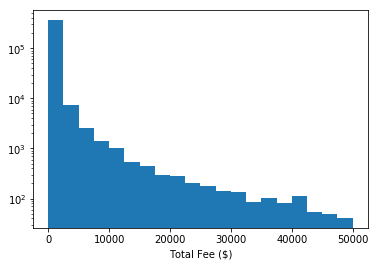

In [181]:
quantile1_fee, median_fee, quantile3_fee = bp_test.TOTAL_FEES.quantile([.25,.5,.75])
mean_fee = bp_test.TOTAL_FEES.mean()
print('Quantiles: ', quantile1_fee, median_fee, quantile3_fee)
print('Mean: ', mean_fee)
plt.figure()
plt.hist(bp_test['TOTAL_FEES'], bins=20, range=(0,50000), log=True)
plt.xlabel('Total Fee ($)')
plt.show()

Now I will divide the whole dataset into 10 equal quantiles by total fee.  For each quantile I'll extract the average comment length and the frequency with which some representative words appear.  The word frequency is given by

$ Word Frequency = (word count) / (total #words in quantile) $

The code below loops over quantiles and prints/saves the key values.

In [265]:
fees=[0]*10
lowers=[0]*10
for i in range(1,11):
    fees[i-1]= bp_test.TOTAL_FEES.quantile(0.1*i)
    lowers[i-1] = bp_test.TOTAL_FEES.quantile(0.1*(i-1))
    
avg_comment_length = [0]*10
new_arr = [0]*10
office_arr = [0]*10
boiler_arr = [0]*10
water_arr = [0]*10
replace_arr = [0]*10
for i in range(len(fees)):
    fee_df = bp_test.loc[(bp_test.TOTAL_FEES<fees[i]) & (bp_test.TOTAL_FEES>lowers[i])]
    fee_freq = pd.Series(' '.join(fee_df.Comments).split())
    fee_word_freq = fee_freq.value_counts()[fee_freq.value_counts()>10]
    print('%.0f < fee < %.0f ' % (lowers[i],fees[i]))
    print('Avg comment length: ', 10*fee_freq.count()/len(bp_test.index))
    avg_comment_length[i] = 10*fee_freq.count()/len(bp_test.index)
    print(fee_word_freq.sort_values(ascending=False).head(10))
    new_arr[i] = fee_word_freq.loc['new']/fee_freq.count()
    office_arr[i] = fee_word_freq.loc['office']/fee_freq.count()
    boiler_arr[i] = fee_word_freq.loc['boiler']/fee_freq.count()
    water_arr[i] = fee_word_freq.loc['water']/fee_freq.count()
    replace_arr[i] = fee_word_freq.loc['replace']/fee_freq.count()

-770 < fee < 25 
Avg comment length:  4.70514072440232
install     4511
new         3783
replace     2955
2           2411
existing    2031
work        1999
gas         1781
issued      1748
water       1739
floor       1720
dtype: int64
25 < fee < 30 
Avg comment length:  1.8795979227588457
gas         3360
install     2357
new         2255
boiler      2069
replace     1820
furnace     1442
light       1421
existing    1032
2           1015
bathroom    975 
dtype: int64
30 < fee < 35 
Avg comment length:  1.2955120325746787
gas        2370
boiler     1778
new        1675
install    1551
replace    1142
light      1011
kitchen    719 
floor      694 
2          668 
fixture    628 
dtype: int64
35 < fee < 50 
Avg comment length:  7.988139826861476
install     9224
new         7798
kitchen     5406
replace     4727
floor       4543
2           4446
gas         4282
1           3884
existing    3620
bathroom    3460
dtype: int64
50 < fee < 65 
Avg comment length:  5.116746111753048
insta

To make sure we understand how the total fee affects comments in general, let's plot them against one another.

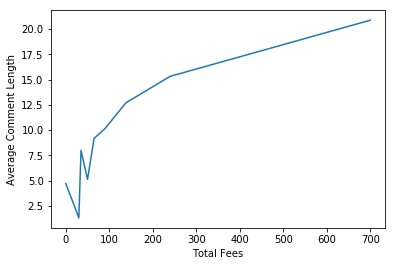

In [256]:
bins = lowers.copy()
bins[0] = 0
plt.figure()
plt.plot(bins,avg_comment_length)
plt.ylabel('Average Comment Length')
plt.xlabel('Total Fees')
plt.show()

There's a clear direct correlation between total fee and average comment length, which makes sense because more involved, expensive projects might require more-detailed descriptions.

Now let's examine five different common words plotted over total fee.

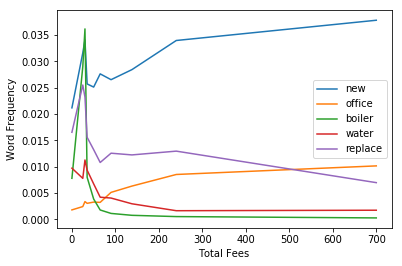

In [266]:
plt.figure()
plt.plot(bins,new_arr, label='new')
plt.plot(bins,office_arr, label='office')
plt.plot(bins,boiler_arr, label='boiler')
plt.plot(bins,water_arr, label='water')
plt.plot(bins,replace_arr, label='replace')
plt.ylabel('Word Frequency')
plt.xlabel('Total Fees')
plt.legend()
plt.show()

This plot shows some clear trends!

1. The term "new" is ambiguous--it could refer to a replacement or to a brand new installation.  As such, it remains a highly-used word at all fee levels.
2. The terms "water" and "replace" is used frequently in the low-fee range, then falls off more slowly.
3. The term "boiler" is used extremely frequently in a narrow low-fee range and almost not-at-all in the very lowest-fee or high-fee ranges.  This might indicate smaller maintenance projects with a consistent fee.
4. The term "office" is used almost never for low-fee projects and rises with the fee.

Trends like these show that dividing the comments section by theme is meaningful, and that there is substantial information to be dredged from the unstructured text.